In [1]:
library(caret)
library(nnet)
library(party)
library(randomForest)
library(e1071)
library(dplyr)
library(tidyverse)
library(lubridate)

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin


Attaching package: ‘dplyr’

The following object is masked from ‘package:randomForest’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, 

In [2]:
cn <- read.csv("Rdata/calltaxi.csv")
#cn <- arrange(cn, 배차시간)
head(cn)
str(cn)

X,배차일,배차요일,배차시간,승차일,승차요일,승차시간,출발지구군,출발지상세,대기,대기시간,휴일,맑음,시간
0,2020-01-01,2,03:01:40,2020-01-01,2,03:19:01,중구,명동,17.35,2,0,1,03
1,2020-01-01,2,03:07:51,2020-01-01,2,03:35:13,중구,신당제5동,27.37,3,0,1,03
2,2020-01-01,2,03:01:24,2020-01-01,2,03:24:33,강북구,번제3동,23.15,3,0,1,03
3,2020-01-01,2,04:15:07,2020-01-01,2,04:28:58,영등포구,여의동,13.85,2,0,1,04
4,2020-01-01,2,04:13:50,2020-01-01,2,04:35:41,금천구,독산제1동,21.85,3,0,1,04
5,2020-01-01,2,03:41:22,2020-01-01,2,03:54:40,강남구,논현2동,13.30,2,0,1,03


'data.frame':	280227 obs. of  14 variables:
 $ X         : int  0 1 2 3 4 5 6 7 8 9 ...
 $ 배차일    : Factor w/ 120 levels "2020-01-01","2020-01-02",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ 배차요일  : Factor w/ 8 levels "0","1","2","3",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ 배차시간  : Factor w/ 55510 levels "00:00:01","00:00:03",..: 1323 1391 1321 2262 2242 1797 2041 2456 2036 2083 ...
 $ 승차일    : Factor w/ 120 levels "2020-01-01","2020-01-02",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ 승차요일  : int  2 2 2 2 2 2 2 2 2 2 ...
 $ 승차시간  : Factor w/ 56416 levels "00:00:01","00:00:03",..: 1656 1797 1698 2439 2528 1996 2577 2602 2485 2543 ...
 $ 출발지구군: Factor w/ 52 levels "","강남구","강동구",..: 49 49 4 43 16 2 50 34 22 29 ...
 $ 출발지상세: Factor w/ 612 levels "","가능3동","가락1동",..: 152 328 193 387 123 91 147 408 490 584 ...
 $ 대기      : num  17.4 27.4 23.1 13.8 21.9 ...
 $ 대기시간  : int  2 3 3 2 3 2 4 2 4 4 ...
 $ 휴일      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ 맑음      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ 시간      : Factor w/ 25 levels "00","01","02",.

In [3]:
nrow(cn)
colSums(is.na(cn))

[1] 280227

X     배차일   배차요일   배차시간     승차일   승차요일   승차시간 
         0          0          0          0          0          0          0 
출발지구군 출발지상세       대기   대기시간       휴일       맑음       시간 
         0          0         28         28          0          0          0

In [4]:
cn <- subset(cn, !is.na(cn$대기))
nrow(cn)

[1] 280199

In [5]:
cn <- subset(cn, !is.na(cn$대기시간))
nrow(cn)

[1] 280199

In [6]:
cn$대기 <- abs(cn$대기)
table(cn$출발지구군,cn$대기)

                
                  0 0.05 0.07 0.08 0.1 0.12 0.13 0.15 0.17 0.18 0.2 0.22 0.23
                  0    0    0    0   0    0    0    0    0    0   0    0    0
  강남구          4    1    0    0   5    0    0    1    0    0   3    0    0
  강동구          2    4    0    0   6    0    0   11    0    0   3    1    0
  강북구          2    0    0    0   0    0    0    7    0    0   4    0    0
  강서구          0    1    0    0   2    0    0    5    0    0   8    0    0
  고양시덕양구    0    0    0    0   1    0    0    2    0    0   2    0    0
  고양시일산동구  0    0    0    0   0    0    0    2    0    0   0    0    0
  고양시일산서구  0    0    0    0   0    0    0    0    0    0   1    0    0
  과천시          0    0    0    0   0    0    0    0    0    0   0    0    0
  관악구          0    1    0    0   4    0    0   11    0    0   8    1    0
  광명시          0    0    0    0   2    0    0    0    0    0   1    0    0
  광주시          0    0    0    0   0    0    0    0    0    0   0    0    0
  광진구        

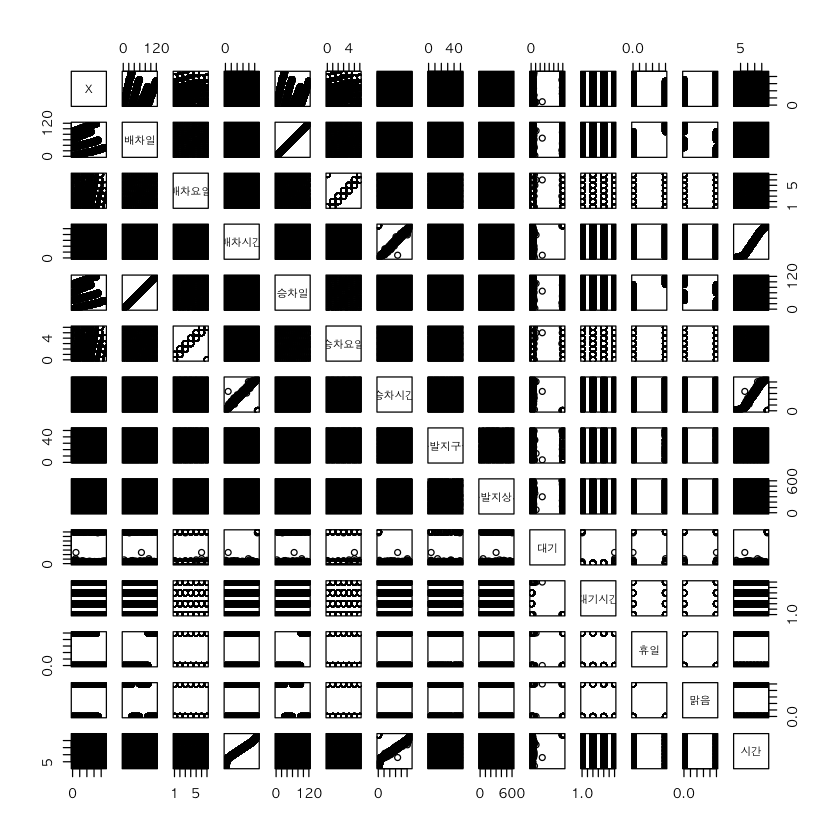

In [7]:
options(warn = -1)
par(family = "AppleGothic")
plot(cn)

In [ ]:
boxplot(cn$대기)

In [ ]:
options(warn = -1)
par(family = "AppleGothic")
plot(table(cn$출발지구군))

In [ ]:
options(warn = -1)
par(family = "AppleGothic")
plot(table(cn$배차요일))

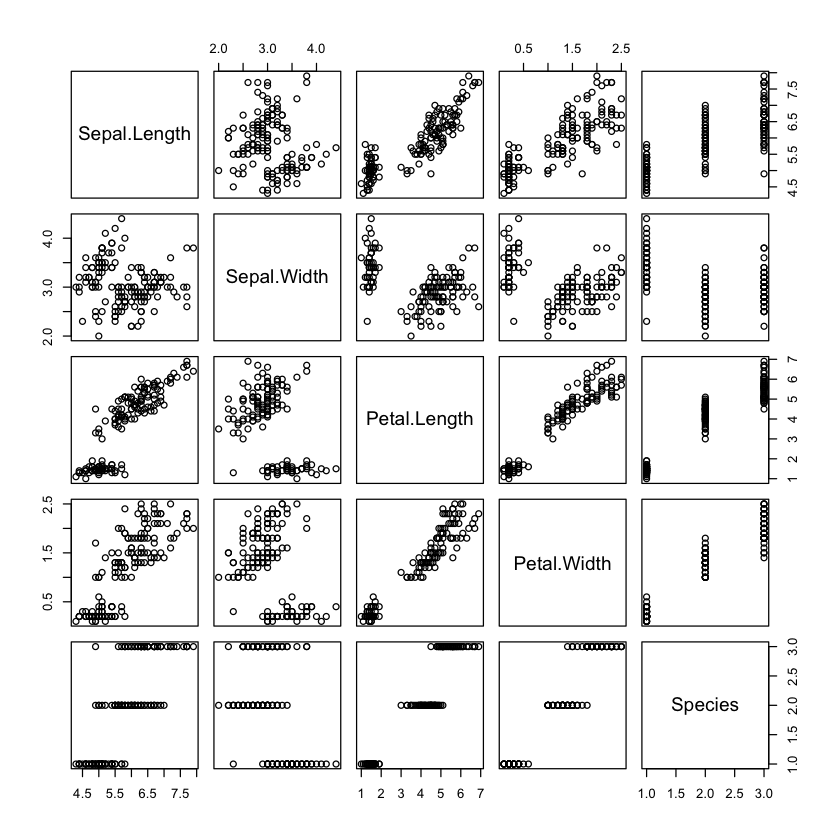

In [9]:
plot(iris)

In [ ]:
str(cn)
summary(cn)
table(cn$대기시간)
sum(is.na(cn))

In [ ]:
대기시간1 <- sample(1:5886,1000)
대기시간2 <- sample(5887:21105,1000)
대기시간3 <- sample(21106:26822,1000)
대기시간4 <- sample(26823:28020,1000)
cn2 <- rbind(cn[대기시간1,],cn[대기시간2,],cn[대기시간3,],cn[대기시간4,])

cn2$대기시간 <- as.factor(cn2$대기시간)
str(cn2)
sum(is.na(cn2))


In [ ]:
# 표준화 작업하기
#cn$대기시간factor <- as.factor(cn$대기시간)
#cn

In [ ]:
summary(cn)

In [ ]:
sum(is.na(cn))

In [ ]:
#cn <- cn[,-c(1,3)]

In [ ]:
#table(cn$대기시간factor)

In [ ]:
#samp <- c(sample(1:5886,1000),sample(5887:21105,1000),sample(21106:26822,1000),sample(26823:28020,1000))
#samp

In [ ]:
samp <- createDataPartition(cn2$대기시간, p=0.7, list=F)
data.tr <- cn2[samp,]
data.test <- cn2[-samp,]
x <- subset(data.test, select = -대기시간)
y <- data.test$대기시간
model.ctree <- ctree(대기시간 ~., data=data.tr)
의pred <- predict(model.ctree, x)
mean(의pred == y)
table(의pred, y)

In [ ]:
samp <- createDataPartition(cn2$대기시간, p=0.7, list=F)
data.tr <- cn2[samp,]
data.test <- cn2[-samp,]
x <- subset(data.test, select = -대기시간)
y <- data.test$대기시간
model.rf <- randomForest(대기시간 ~ ., data=data.tr, ntree = 2)
Rpred <- predict(model.rf, x)
mean(Rpred == y)
table(Rpred, y)

---

In [ ]:
#samp <- createDataPartition(cn$대기시간factor, p=0.7, list=F)
data.tr <- cn2[samp,]
data.test <- cn2[-samp,]
x <- subset(data.test, select = -대기시간)
y <- data.test$대기시간

model.nnet <- nnet(대기시간 ~ ., data=data.tr, size=4)
model.ctree <- ctree(대기시간 ~., data=data.tr)
model.rf <- randomForest(대기시간 ~ ., data=data.tr, ntree = 100)
model.svm <- svm(대기시간 ~ . , data=data.tr)
model <- multinom(대기시간 ~., data=data.tr)

인pred <- predict(model.nnet, x, type = "class")
의pred <- predict(model.ctree, x)
Rpred <- predict(model.rf, x)
Spred <- predict(model.svm, x)
로pred <- predict(model, x)

인공신경망 <-  mean(인pred == y)
의사결정나무 <- mean(의pred == y)
RandomForest <- mean(Rpred == y)
SVM <- mean(Spred == y)
로지스틱회귀분석 <- mean(로pred == y)

paste("인공신경망 :", 인공신경망)
paste("의사결정나무 :", 의사결정나무)
paste("RandomForest :", RandomForest)
paste("SVM :", SVM)
paste("로지스틱회귀분석 :", 로지스틱회귀분석)